Land cover classification is a crucial task for monitoring and managing land resources, especially for agricultural purposes. One of the most challenging but significant classifications is cropland identification, which can be vital for monitoring agricultural activities, food security, and land-use changes. The goal of this project is to develop a machine learning algorithm to classify and identify croplands using Sentinel satellite imagery.

entinel satellites, specifically those from the Sentinel-1 and Sentinel-2 missions, provide a wealth of high-resolution data that is invaluable for land cover classification. Sentinel-2's multispectral imagery offers frequent revisit times and high spatial resolution, which makes it ideal for monitoring agricultural landscapes and detecting seasonal changes in croplands. This dataset includes information across multiple bands, such as the Red, Green, Blue, Near-Infrared, and Shortwave Infrared bands, which are particularly useful for distinguishing croplands from other land cover types.

In [ ]:
# Loading libraries, the set I alway use...


# File handling and directory operations
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline


# Satellite Image Classification Project

This project aims to build familiarity with satellite image classification, using the RGB subset of the EuroSAT dataset for exploratory analysis. The EuroSAT dataset is a benchmark for classifying land use and land cover in Europe, and its RGB subset provides a simplified entry point by focusing on red, green, and blue channels. This initial exploration will help understand the data and its structure before moving to more complex tasks.

In PyTorch, an excellent choice for working with semi-structured image datasets is the `torchvision.datasets.ImageFolder` class. This class is typically used for loading datasets where images are organized into subdirectories corresponding to their class labels. Each subdirectory contains images of a specific class, and `ImageFolder` automatically assigns labels based on folder names.

The first step is to organize the data in the structure required by `ImageFolder`:

i.e root/
    class_1/
        img001.png
        img002.png
        ...
    class_2/
        img001.png
        img002.png
        ...

        
This folder organization ensures that `ImageFolder` can efficiently load the dataset and assign the appropriate labels for each image. The RGB EuroSAT dataset can be arranged in this format for seamless integration into PyTorch workflows.


In [ ]:


# Load the data as a  main path
main_path = '/home/hernan/MLmodels/EuroSat/2750'

# Get the list of folders (directories) in the specified path
folder_names = [folder for folder in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, folder))]

# Print the folder names
for folder in folder_names:
    print(folder)


River
Forest
AnnualCrop
Pasture
Highway
HerbaceousVegetation
Residential
PermanentCrop
SeaLake
Industrial


In [ ]:
#Split in the data in ['train', 'test', 'val']
 
def split_images(input_folder, output_folder, test_size=0.2, val_size=0.05):
    for phase in ['train', 'test', 'val']:
        os.makedirs(os.path.join(output_folder, phase), exist_ok=True)

    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        train_files, test_val_files = train_test_split(files, test_size=test_size + val_size)
        val_split = val_size / (test_size + val_size)
        val_files, test_files = train_test_split(test_val_files, test_size=1 - val_split)

        for phase, phase_files in zip(['train', 'test', 'val'], [train_files, test_files, val_files]):
            phase_folder = os.path.join(output_folder, phase, folder_name)
            os.makedirs(phase_folder, exist_ok=True)
            for file in phase_files:
                shutil.copy(file, phase_folder)

        print(f"Class '{folder_name}': {len(train_files)} train, {len(test_files)} test, {len(val_files)} val images.")

# Paths for the dataset and output folder
main_path = '/home/hernan/MLmodels/EuroSat/2750'
output_path = '/home/hernan/MLmodels/EuroSat/split_data'

# Split data into train, test, and validation sets
split_images(main_path, output_path)


Class 'River': 1875 train, 500 test, 125 val images.
Class 'Forest': 2250 train, 600 test, 150 val images.
Class 'AnnualCrop': 2250 train, 600 test, 150 val images.
Class 'Pasture': 1500 train, 400 test, 100 val images.
Class 'Highway': 1875 train, 500 test, 125 val images.
Class 'HerbaceousVegetation': 2250 train, 600 test, 150 val images.
Class 'Residential': 2250 train, 600 test, 150 val images.
Class 'PermanentCrop': 1875 train, 500 test, 125 val images.
Class 'SeaLake': 2250 train, 600 test, 150 val images.
Class 'Industrial': 1875 train, 500 test, 125 val images.


In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

# Define the directories for training and testing data
train_dir = output_path + '/train'
test_dir = output_path + '/test'

# Define the transformations with data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize(255),  # Resize the images
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(30),  # Randomly rotate images by up to 30 degrees
    transforms.CenterCrop(224),  # Crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image for ResNet
])

# Define the transformations for the testing set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(255),  # Resize the images
    transforms.CenterCrop(224),  # Crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image for ResNet
])

# Load the training dataset with augmentation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the testing dataset without augmentation
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the number of batches in train_loader and test_loader
print(f'Training batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')


Training batches: 633
Test batches: 169


In [34]:
train_loader.dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
# New way (using weights)
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the last layer to match the number of classes in your dataset
num_classes = len(train_loader.dataset.classes)  # The number of classes based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU (if available)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize metrics lists
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

# Training loop
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Loop through the training data
    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Collect predictions and true labels
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Calculate accuracy for this epoch
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    train_accuracies.append(accuracy)

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1s.append(f1)

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Optionally, you can save the model after training
from datetime import datetime

# Save the model with a unique name based on the current time
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'trained_model_{timestamp}.pth'
torch.save(model.state_dict(), filename)


In [ ]:

# After training, you can plot the metrics if needed
import matplotlib.pyplot as plt


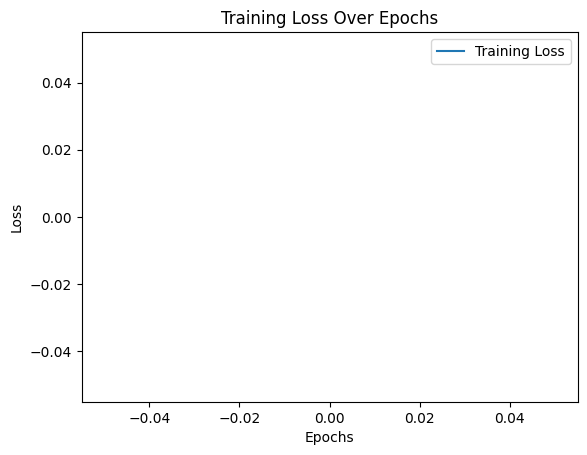

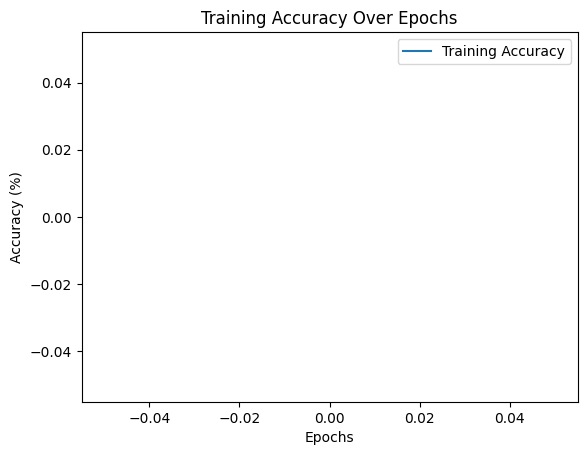

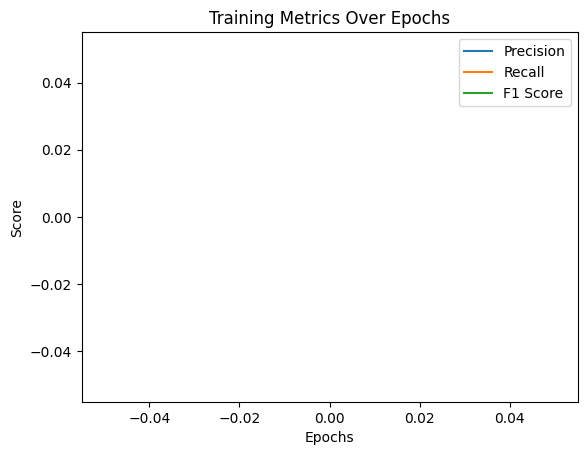

In [29]:

# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Plot precision, recall, F1 score
plt.plot(train_precisions, label='Precision')
plt.plot(train_recalls, label='Recall')
plt.plot(train_f1s, label='F1 Score')
plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()


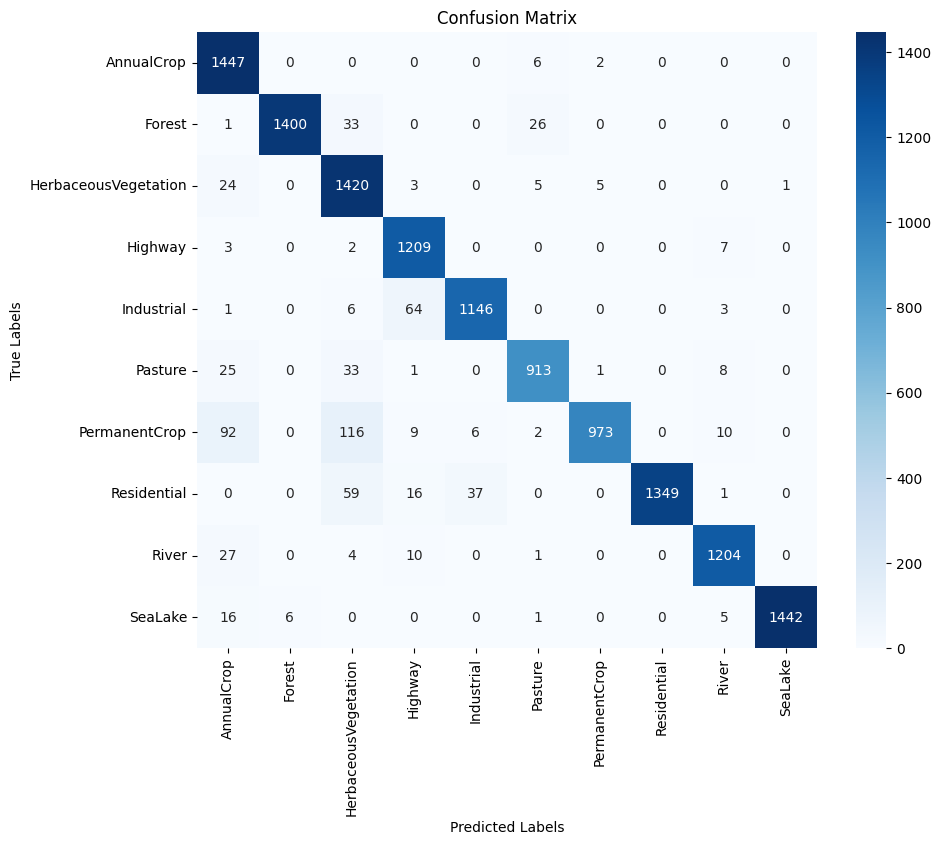

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model and compute the confusion matrix
def evaluate_model(model, data_loader, classes):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(classes)))

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

# Evaluate the model on the test set
classes = train_loader.dataset.classes  # Get the class names from the dataset
confusion_matrix_result = evaluate_model(model, test_loader, classes)


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the image transformation (same as used in training)
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

def predict_image(image_path, model, transform, device, classes):
    """
    Predicts the class of a single image using a trained model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained PyTorch model.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (str): Device to use ('cuda' or 'cpu').
        classes (list): List of class names.

    Returns:
        str: Predicted class label.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    # Map prediction to class name
    predicted_label = classes[predicted_class.item()]
    return predicted_label


# Example usage
if __name__ == "__main__":
    # Path to the image
    image_path = "/home/hernan/MLmodels/EuroSat/split_data/test/Industrial/Industrial_62.jpg"

    # List of classes
    classes = train_loader.dataset.classes  # Automatically extracted from dataset

    # Predict
    predicted_label = predict_image(image_path, model, transform, device, classes)
    print(f"Predicted Label: {predicted_label}")


In [12]:
# Load the pre-trained ResNet model
# New way (using weights)
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# Modify the last layer to match the number of classes in your dataset
num_classes = 10  # The number of classes based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [13]:
model.load_state_dict(torch.load('/home/hernan/MLmodels/EuroSat/trained_model.pth'))
model.eval()  # Ensure the model is in evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == "__main__":
    model.load_state_dict(torch.load('/home/hernan/MLmodels/EuroSat/trained_model.pth'))

    # Path to the image
    image_path = "/home/hernan/MLmodels/EuroSat/split_data/test/Forest/Forest_4.jpg"

    # List of classes
    classes = ['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake'] # Automatically extracted from dataset

    # Predict
    predicted_label = predict_image(image_path, model, transform, device, classes)
    print(f"Predicted Label: {predicted_label}")


Predicted Label: Forest


#### Now it's time to try segmentation, but what is segmentation?, what it is in the context of DeepLearning and for what is usefull?

Here some explanations that can help to understand the task,

### What is Segmentation in the Context of Deep Learning?
Segmentation in the context of deep learning refers to the task of partitioning an image into meaningful regions, where each region corresponds to a specific object or class of interest. Specifically, in semantic segmentation, the goal is to classify each pixel in an image into a predefined category. For example, in satellite imagery, you could classify each pixel as belonging to categories such as forest, lake, urban, or agriculture. Instance segmentation goes a step further by not only classifying pixels but also distinguishing between individual objects of the same class (e.g., multiple cars or trees).

In deep learning, semantic segmentation typically uses convolutional neural networks (CNNs) or advanced models like UNet, DeepLabV3+, and Mask R-CNN to perform pixel-wise classification. These models learn hierarchical representations of the image at various scales, enabling them to understand spatial relationships and complex patterns across an image.



## Implementing Semantic Segmentation Models (UNet and DeepLabV3+) with Bayesian Search
Below, I describe a practical approach to implementing segmentation models with PyTorch, optimizing hyperparameters using Bayesian Search, and efficiently using your GPU resources.